In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install wandb
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=98e59abd6805f0327d09f2c0550fa41c92af2b091b2bf4c46d4b70e536a29973
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=8f0761d52e3807cdd3fda90732bcdf16a0ff27ca04b2a45904779c506470ff2c
  Stored in 

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/csc2231')

In [4]:
def plot_images_final(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

In [5]:
import argparse, logging, copy
from types import SimpleNamespace
from contextlib import nullcontext

import torch
from torch import optim
import torch.nn as nn
from torch.nn.utils import prune
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from fastprogress import progress_bar

import wandb
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

from torch.fft import fft2, ifft2
from fvcore.nn import FlopCountAnalysis

from modules import UNet_conditional, EMA
from filtering import ImageFilter
from unet_compressed_v1 import UNet_conditional_student_v1
from unet_compressed_v2 import UNet_conditional_student_v2

In [6]:
class Diffusion:
	def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, num_classes=10, c_in=3, c_out=3, device="cuda", version=1, **kwargs):
		self.noise_steps = noise_steps
		self.beta_start = beta_start
		self.beta_end = beta_end

		self.beta = self.prepare_noise_schedule().to(device)
		self.alpha = 1. - self.beta
		self.alpha_hat = torch.cumprod(self.alpha, dim=0)

		self.version = version

		self.img_size = img_size
		if version==1:
			self.model = UNet_conditional_student_v1(c_in, c_out, num_classes=num_classes,**kwargs).to(device)
		elif version==2:
			self.model = UNet_conditional_student_v2(c_in, c_out, num_classes=num_classes,**kwargs).to(device)
		self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
		self.device = device
		self.c_in = c_in
		self.num_classes = num_classes

	def alpha_beta(self):
		return (self.alpha, self.beta, self.alpha_hat)

	def prepare_noise_schedule(self):
		return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

	def sample_timesteps(self, n):
		return torch.randint(low=1, high=self.noise_steps, size=(n,))

	def noise_images(self, x, t):
		"Add noise to images at instant t"
		sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
		sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
		Ɛ = torch.randn_like(x)
		return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ


	#new pruning function - modified
	def pruning(self, model):

		mod = copy.deepcopy(model).to(device)
		l1_prune = torch.nn.utils.prune.L1Unstructured(0.3)

		for name,module in mod.named_modules():

			if isinstance(module,nn.Linear):
				l1_prune.apply(module,name='weight',amount=0.3)

			elif isinstance(module,nn.Conv2d):
				l1_prune.apply(module,name='weight',amount=0.3)

		return mod


	def find_weights(self,weights,bits):

		min_wt, max_wt = weights.min(), weights.max()
		qmin, qmax = -2.0 ** (bits - 1), 2.0 ** (bits - 1) - 1

		scale = (max_wt - min_wt) / (qmax - qmin)

		zero_point = qmin - min_wt / scale

		quantized_weights = torch.round(weights / scale + zero_point)
		quantized_weights = torch.clamp(quantized_weights, qmin, qmax).int()

		return quantized_weights

	#new manual quantization function
	def quantize_eval(self,model):

		for param_name, param in model.named_parameters():

			if 'weight' in param_name:
				new_name = param_name.replace(".", "_")
				quantized_weights = self.find_weights(param.data, bits=8)
				setattr(model, new_name, param)

		return model


	@torch.inference_mode()
	def sample(self, model, labels, cfg_scale=0):
		n = len(labels)
		logging.info(f"Sampling {n} new images....")
		model.eval()
		model = self.quantize_eval(model)
		model = self.pruning(model)


		with torch.inference_mode():
			x = torch.randn((n, self.c_in, self.img_size, self.img_size)).to(self.device)
			for i in progress_bar(reversed(range(1, self.noise_steps)), total=self.noise_steps-1, leave=False):
				t = (torch.ones(n) * i).long().to(self.device)
				predicted_noise = model(x, t, labels)
				if cfg_scale > 0:
					uncond_predicted_noise = model(x, t, None)
					predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
				alpha = self.alpha[t][:, None, None, None]
				alpha_hat = self.alpha_hat[t][:, None, None, None]
				beta = self.beta[t][:, None, None, None]
				if i > 1:
					noise = torch.randn_like(x)
				else:
					noise = torch.zeros_like(x)
				x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
		x = (x.clamp(-1, 1) + 1) / 2
		x = (x * 255).type(torch.uint8)
		return x

	#new plot images function integrated with image filters
	def plot_images(self,images):

		ilist = []
		filter_instance = ImageFilter(filter_type='weighted', weight = [0.25, 0.25, 0.25, 0.25])

		for i in images.cpu():
			image = cv2.cvtColor(i.permute(1,2,0).numpy(),cv2.COLOR_RGBA2RGB)
			filtered_image = filter_instance.apply_filter(image)
			ilist.append(filtered_image)

		ilist = torch.Tensor(np.array(ilist))
		return ilist

	#new method to analyze time
	def analyze_time(self, model, inp, t, y):
		with profile(activities=[ProfilerActivity.CUDA], record_shapes=True) as prof:
			with record_function("model_inference"):
				model(x=inp,t=t,y=y)
		print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

	def count_parameters(self, model):
		return sum(p.numel() for p in model.parameters())

	def count_flops(self, model, inputs, t, y):
		flops = FlopCountAnalysis(model, (inputs, t, y))
		return flops.total()

	def model_size(self, model):
		param_size = 0
		buffer_size = 0
		for param in model.parameters():
			param_size += param.nelement() * param.element_size()

		for buffer in model.buffers():
			buffer_size += buffer.nelement() * buffer.element_size()

		size_all_mb = (param_size + buffer_size) / 1024**2
		print('Size: {:.3f} MB'.format(size_all_mb))

		return size_all_mb

In [7]:
# Calculating the model statistics
n = 10
device = "cuda"
version = 1
obj_class= 1

if version==1:
    model = UNet_conditional_student_v1(num_classes=10, remove_deep_conv=True).to(device)
    ckpt = torch.load("/content/drive/MyDrive/csc2231/models/v1/ema_student_ckpt.pt")
elif version==2:
    model = UNet_conditional_student_v2(num_classes=10, remove_deep_conv=False).to(device)
    ckpt = torch.load("/content/drive/MyDrive/csc2231/models/v1/ema_student_ckpt.pt")

model = model.eval().requires_grad_(False)
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device, version=version)

# Number of flops
input = torch.randn((n, 3, 64, 64)).to(device)
t = (torch.ones(n)).long().to(device)
y = torch.Tensor([obj_class] * n).long().to(device)
num_flops = diffusion.count_flops(model, input, t, y)

# Number of parameters
num_parameters = diffusion.count_parameters(model)

# Model size
model_size = diffusion.model_size(model)

# Analyze time
input = torch.randn((10, 3, 64, 64)).to(device)
t = (torch.ones(n)).long().to(device)
y = torch.Tensor([obj_class] * n).long().to(device)
diffusion.analyze_time(model, input, t=t, y=y)

print(f"Number of parameters: {num_parameters}")
print(f"Number of flops: {num_flops}")
print(f"Model size: {model_size} MB")

bot3, bot3.double_conv, bot3.double_conv.0, bot3.double_conv.1, bot3.double_conv.2, bot3.double_conv.3, bot3.double_conv.4, sa1.mha.out_proj, sa2.mha.out_proj, sa3.mha.out_proj, sa4.mha.out_proj, sa5.mha.out_proj, sa6.mha.out_proj


Size: 30.204 MB
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
void at::native::(anonymous namespace)::cunn_SoftMax...         0.00%       0.000us         0.00%       0.000us       0.000us       7.634ms        22.30%       7.634ms       7.634ms             1  
                                  volta_sgemm_32x128_nn         0.00%       0.000us         0.00%       0.000us       0.000us       6.149ms        17.97%       6.149ms       2.050ms          

In [ ]:
n = 10
device = "cuda"
obj_class = 1

if version==1:
    model = UNet_conditional_student_v1(num_classes=10, remove_deep_conv=True).to(device)
    ckpt = torch.load(r"/content/drive/MyDrive/csc2231/models/v1/ema_student_ckpt.pt")
elif version==2:
    model = UNet_conditional_student_v2(num_classes=10, remove_deep_conv=False).to(device)
    ckpt = torch.load(r"/content/drive/MyDrive/csc2231/models/v2/ema_student.ckpt.pt")

model = model.eval().requires_grad_(False)
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
num_parameters = diffusion.count_parameters(model)
y = torch.Tensor([obj_class] * n).long().to(device)

start_time = time.process_time()
x = diffusion.sample(model, y, cfg_scale=3)
#ilist = diffusion.plot_images(x)
end_time = time.process_time()

print("Time elapsed: ", end_time-start_time)
plot_images_final(x)

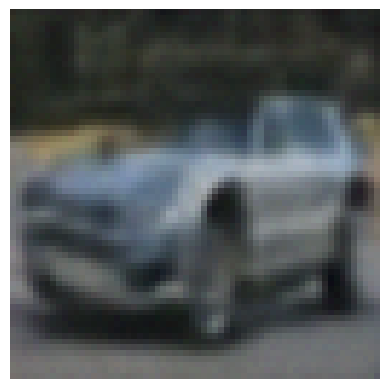

In [21]:
# Save one image
generated_img = x[9].cpu().permute(1, 2, 0)
plt.imshow(generated_img)
plt.axis('off')  # Optional: turn off axis
plt.savefig('/content/drive/MyDrive/csc2231/results/Teacher/teacher_5.png')

In [ ]:
print(x.shape)

torch.Size([10, 3, 64, 64])


## Run inference with script

In [26]:
#rm -rf '/content/MobileGen'

In [27]:
!git clone 'https://github.com/01pooja10/MobileGen.git'

Cloning into 'MobileGen'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 270 (delta 45), reused 0 (delta 0), pack-reused 187
Receiving objects: 100% (270/270), 352.05 KiB | 11.36 MiB/s, done.
Resolving deltas: 100% (138/138), done.


In [28]:
sys.path.append('/content/MobileGen/DDPM/scripts')

In [21]:
from updated_inference import infer

In [34]:
generated_image = infer(obj_class=1, version=2)

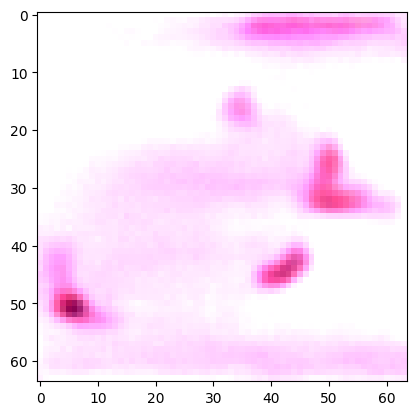

In [38]:
plt.imshow(generated_image)